# Setup

In [2]:
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [4]:
# Get the current working directory (where the script is running)
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'data', 'raw', 'hotelrec_final_cleaned.csv')
file_path

'/root/cmpe256/cmpe256_hotel_recommendation_system/data/raw/hotelrec_final_cleaned.csv'

In [5]:
# --- Parameters ---
chunk_size = 1_000_000  # adjust based on memory

In [6]:
# --- Preview First Chunk ---
reader = pd.read_csv(file_path, chunksize=chunk_size)
first_chunk = next(reader)

print(f"First chunk shape: {first_chunk.shape}")
display(first_chunk.head())

First chunk shape: (1000000, 13)


,hotel_id,hotel_name,hotel_location,author,date,rating,sentiment_score,sleep quality,value,rooms,service,cleanliness,location
0,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,violettaf340,2019-01,5.0,0.341327,NaN,NaN,NaN,NaN,NaN,NaN
1,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,Lagaiuzza,2016-01,5.0,0.272183,NaN,NaN,NaN,NaN,NaN,NaN
2,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,ashleyn763,2014-10,5.0,0.475000,NaN,5.0,NaN,5.0,NaN,5.0
3,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,DavideMauro,2014-08,5.0,0.623636,5.0,NaN,NaN,5.0,5.0,NaN
4,1121769,Hotel Baltic,Giulianova Province of Teramo Abruzzo,Alemma11,2013-08,4.0,0.218607,3.0,4.0,4.0,5.0,3.0,4.0


In [7]:
# --- Initialize for full processing ---
reader = pd.read_csv(file_path, chunksize=chunk_size)

# Basic EDA

In [6]:
# --- Initialize accumulators ---
row_count = 0
column_types = None
null_counts = None
unique_counts = None
duplicate_rows_count = 0

# --- Process in chunks ---
for chunk in reader:
    row_count += chunk.shape[0]

    if column_types is None:
        column_types = chunk.dtypes

    if null_counts is None:
        null_counts = chunk.isnull().sum()
    else:
        null_counts += chunk.isnull().sum()

    if unique_counts is None:
        unique_counts = chunk.nunique()
    else:
        unique_counts += chunk.nunique()  # approximate

    duplicate_rows_count += chunk.duplicated().sum()

In [7]:
# --- Summaries ---
print(f"\nTotal Rows: {row_count}")
print("\nColumn Types:")
print(column_types)


Total Rows: 50240453

Column Types:
hotel_id             int64
hotel_name          object
hotel_location      object
author              object
date                object
rating             float64
sentiment_score    float64
sleep quality      float64
value              float64
rooms              float64
service            float64
cleanliness        float64
location           float64
dtype: object


In [8]:
print("\nMissing Values:")
missing_percent = (null_counts / row_count) * 100
missing_df = pd.DataFrame({'Missing Count': null_counts, 'Missing %': missing_percent})
display(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))


Missing Values:


,Missing Count,Missing %
sleep quality,27661163,55.057551
rooms,24841201,49.444620
location,24736006,49.235237
value,23872185,47.515863
cleanliness,23852817,47.477313
service,14687134,29.233681


In [9]:
print(f"\nNumber of Duplicated Rows: {duplicate_rows_count}")


Number of Duplicated Rows: 0


In [10]:
print("\nApproximate Unique Values per Column:")
display(unique_counts.sort_values(ascending=False))


Approximate Unique Values per Column:


author             44239273
sentiment_score    21043643
hotel_id             366142
hotel_name           358970
hotel_location       188216
date                  10788
rooms                   281
cleanliness             266
value                   264
location                263
service                 262
sleep quality           255
rating                  255
dtype: int64

Initially thought that 1 hotel = 1 id = 1 name = 1 location.
Reason this could happen:
1. Same Hotel Name for Different Hotels

    Some hotels have same names but are in different locations. 
    Example: 
    "Holiday Inn" in San Francisco, 
    "Holiday Inn" in Los Angeles; 
    Same hotel name, but different hotels and different hotel_ids. 
    Result: → hotel_id > hotel_name

2. Multiple Branches (Chains)

    Hotel chains like "Hilton", "Marriott", etc. have hundreds of locations with the same brand name. 
    Even "Best Western", "Days Inn", "Motel 6", etc. 
    Result: → hotel_name can repeat, hotel_location can differ. 


3. Typos / Slight Variations

    Some names might be slightly different due to spelling or formatting issues: 
    "Grand Hotel" vs. "Grand Hotel " 
    "Hilton, Downtown" vs. "Hilton Downtown" 
    Even the same hotel may be entered differently. 


4. Hotel Locations Grouped

    hotel_location might not be precisely per hotel. 
    It might be city level, state level, or even region level. 
    Many hotels can share the same location ("San Francisco", "Los Angeles", etc.) 
    Result: → hotel_location has far fewer unique values. 


# EDA

## Hotel vs Review

In [8]:
# --- Count number of reviews per hotel_id ---
reader = pd.read_csv(file_path, chunksize=chunk_size)
hotel_review_counts = defaultdict(int)

for chunk in reader:
    chunk_counts = chunk['hotel_id'].value_counts()
    for hotel_id, count in chunk_counts.items():
        hotel_review_counts[hotel_id] += count

In [9]:
# --- Build hotel_id -> hotel_name map --- [~18min]
reader = pd.read_csv(file_path, chunksize=chunk_size)
hotel_id_to_name = {}

for chunk in reader:
    for _, row in chunk[['hotel_id', 'hotel_name']].dropna().iterrows():
        hotel_id = row['hotel_id']
        hotel_name = row['hotel_name']
        if hotel_id not in hotel_id_to_name:
            hotel_id_to_name[hotel_id] = hotel_name  # first occurrence

In [10]:
# --- Create DataFrame for Top Hotels ---
review_df = pd.DataFrame(list(hotel_review_counts.items()), columns=['hotel_id', 'review_count'])
review_df['hotel_name'] = review_df['hotel_id'].map(hotel_id_to_name)

In [11]:
# --- Sort descending and get Top 10 ---
top_hotels = review_df.sort_values(by='review_count', ascending=False).head(10)

In [12]:
# --- Display Top 10 Hotels ---
print("\nTop 10 Hotels by Number of Reviews:")
display(top_hotels[['hotel_id', 'hotel_name', 'review_count']])


Top 10 Hotels by Number of Reviews:


,hotel_id,hotel_name,review_count
340308,278011,Embassy Suites by Hilton Niagara Falls Fallsvi...,10334
339953,219161,Sensimar Resort Riviera Maya,10291
18288,1209793,Center Parcs Whinfell Forest,10187
340309,523986,Center Parcs Longleat Forest,10133
341349,583034,Paradisus Palma Real Golf Spa Resort,10077
337465,181641,Sandals Royal Bahamian Spa Resort Offshore Island,10027
341350,2627483,Secrets The Vine Cancun,9476
340981,243420,Sofitel London Gatwick Hotel,9399
341351,503104,Grand Bahia Principe Tulum,9396
338784,147627,Breezes Resort Spa Bahamas,8832


## Reviews vs Year

In [13]:
# --- Get total rows for progress ---
total_rows = sum(1 for line in open(file_path)) - 1
total_chunks = (total_rows // chunk_size) + 1

total_chunks

51

In [14]:
# --- New fresh reader here ---
reader = pd.read_csv(file_path, chunksize=chunk_size)

In [15]:
# --- Initialize Counter --- [~1min]
reviews_per_year = {}

for chunk in tqdm(reader, total=total_chunks, desc="Processing Yearly Reviews", mininterval=1):
    # Drop rows with missing date
    chunk = chunk.dropna(subset=['date']).copy()

    # Extract year
    chunk['year'] = chunk['date'].apply(lambda x: str(x)[:4])

    # Count reviews by year
    year_counts = chunk['year'].value_counts()

    # Aggregate counts
    for year, count in year_counts.items():
        if year not in reviews_per_year:
            reviews_per_year[year] = count
        else:
            reviews_per_year[year] += count

Processing Yearly Reviews: 100%|█████████████████████████████████████████████████████| 51/51 [00:47<00:00,  1.07it/s]


In [16]:
# --- Convert to DataFrame ---
yearly_reviews_df = pd.DataFrame(list(reviews_per_year.items()), columns=['year', 'review_count'])
yearly_reviews_df = yearly_reviews_df.sort_values(by='year')

# --- Display ---
print("\nReviews per Year:")
display(yearly_reviews_df)


Reviews per Year:


,year,review_count
18,2001,227
17,2002,5765
16,2003,40406
15,2004,101347
14,2005,175543
13,2006,270806
12,2007,399445
11,2008,530424
10,2009,853457
9,2010,1228264


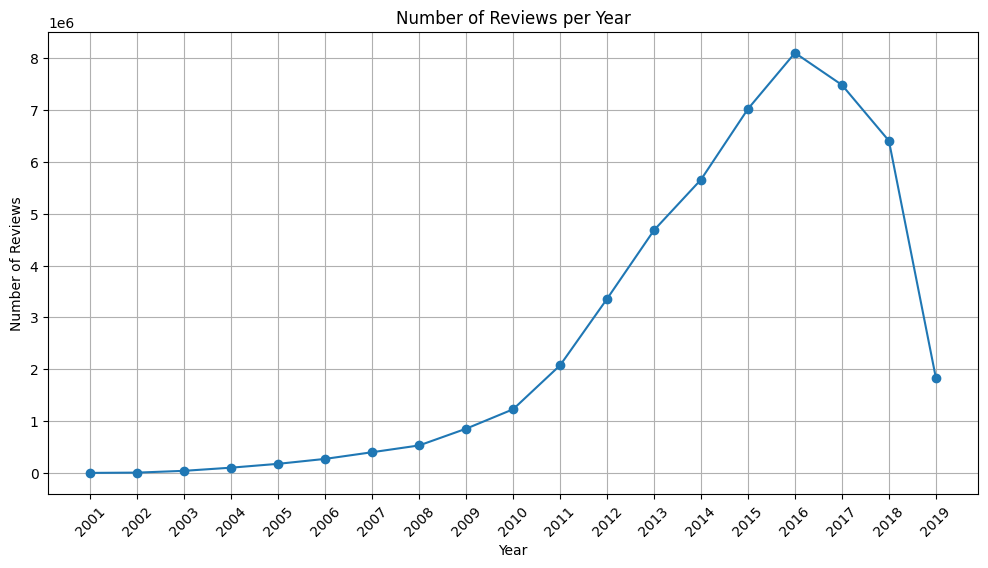

In [17]:
# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(yearly_reviews_df['year'], yearly_reviews_df['review_count'], marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

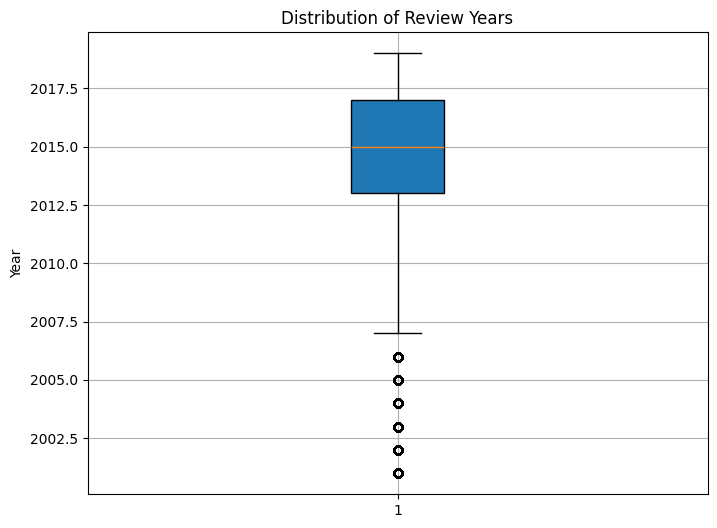

In [20]:
# Create repeated years in a memory-efficient way
years = yearly_reviews_df['year'].astype(int)
weights = yearly_reviews_df['review_count'].astype(int)

# Generate data using numpy (VERY memory efficient)
expanded_years = np.repeat(years.values, weights.values)

# Now plot!
plt.figure(figsize=(8,6))
plt.boxplot(expanded_years, vert=True, patch_artist=True)

plt.title('Distribution of Review Years')
plt.ylabel('Year')
plt.grid(True)
plt.show()

- The majority of your hotel reviews happened between 2013 and 2017. (50%)
- The peak or median review year is around 2015.
- Few hotels had reviews way back from 2002–2006, but they are very rare (shown as outlier circles).
- After ~2017, the number of reviews starts to decline slightly (because top whisker stops around 2018).

In [21]:
print("Median Year:", np.median(expanded_years))
print("Q1 (25th percentile):", np.percentile(expanded_years, 25))
print("Q3 (75th percentile):", np.percentile(expanded_years, 75))
print("Min Year:", expanded_years.min())
print("Max Year:", expanded_years.max())

Median Year: 2015.0
Q1 (25th percentile): 2013.0
Q3 (75th percentile): 2017.0
Min Year: 2001
Max Year: 2019


- The majority of the reviews are heavily concentrated between 2013 and 2017.
- 2015 is the exact "middle" review year → so the dataset is slightly biased toward mid-2010s.
- Very few reviews exist before 2010 (outliers).
- Reviews stopped growing or dataset was collected until 2019 — no reviews after 2019.
- The spread is about 18 years total (from 2001 to 2019), but most data is packed into 5 years (2013–2017).

In [ ]:
# --- Setup ---     [~3m 30s]
current_dir = os.getcwd()
input_path = os.path.join(current_dir, 'data', 'raw', 'hotelrec_final_cleaned.csv')
output_path = os.path.join(current_dir, 'data', 'processed', 'hotelrec_2013_2017.csv')

chunk_size = 1_000_000
first_chunk = True

# --- Get total rows to estimate total_chunks ---
total_rows = sum(1 for line in open(input_path)) - 1  # minus header
total_chunks = (total_rows // chunk_size) + 1

# --- Reader ---
reader = pd.read_csv(input_path, chunksize=chunk_size)

# --- Process chunks with progress bar ---
for chunk in tqdm(reader, total=total_chunks, desc="Filtering 2013-2017 Reviews", mininterval=1):
    # Extract year from date
    chunk = chunk.dropna(subset=['date']).copy()
    chunk['year'] = chunk['date'].apply(lambda x: int(str(x)[:4]))  # safely extract year

    # Filter between 2013 and 2017
    filtered_chunk = chunk[(chunk['year'] >= 2013) & (chunk['year'] <= 2017)]

    # Drop temporary year column
    filtered_chunk = filtered_chunk.drop(columns=['year'])

    # Save to output CSV
    if not filtered_chunk.empty:
        if first_chunk:
            filtered_chunk.to_csv(output_path, index=False, mode='w')
            first_chunk = False
        else:
            filtered_chunk.to_csv(output_path, index=False, mode='a', header=False)

print(f"\nFinished! Saved filtered reviews (2013-2017) to: {output_path}")

Filtering 2013-2017 Reviews: 100%|███████████████████████████████████████████████████| 51/51 [03:20<00:00,  3.93s/it]


Finished! Saved filtered reviews (2013-2017) to: /root/cmpe256/cmpe256_hotel_recommendation_system/data/processed/hotelrec_2013_2017.csv


In [ ]:
# --- Paths --- [~6min]
current_dir = os.getcwd()
input_csv = os.path.join(current_dir, 'data', 'processed', 'hotelrec_2013_2017.csv')
output_csv_gz = os.path.join(current_dir, 'data', 'processed', 'hotelrec_2013_2017.csv.gz')

# --- Read and save compressed ---
df = pd.read_csv(input_csv)

df.to_csv(output_csv_gz, index=False, compression='gzip')

print(f"\nCompressed version saved at: {output_csv_gz}")


Compressed version saved at: /root/cmpe256/cmpe256_hotel_recommendation_system/data/processed/hotelrec_2013_2017.csv.gz


In [5]:
df.shape

(32957031, 13)